# core

> Fill in a module description here

In [ ]:
#| default_exp core

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| export
from nbdev.showdoc import *
import pandas as pd
import numpy as np
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
#| export
def plot_volcano_ma(df, title, protein_indices=None, protein_names=None, protein_colors=None):
    if protein_indices is None:
        protein_indices = []

    if protein_names is None:
        protein_names = []

    if protein_colors is None:
        protein_colors = ['r'] * len(protein_indices)

    df['log10pval'] = -np.log10(df['P.Value'])
    df['log10adjpval'] = -np.log10(df['adj.P.Val'])

    fig, axes = plt.subplots(figsize=(14, 4), ncols=2, nrows=1)

    # Volcano plot
    ax = axes[0]
    df.plot(x='logFC', y='log10adjpval', kind='scatter', s=5, alpha=0.1, ax=ax, c='black')

    # Calculate proportions for -1 and +1 on the x-axis
    xmin, xmax = ax.get_xlim()
    minus_one_normalized = (-1 - xmin) / (xmax - xmin)
    plus_one_normalized = (1 - xmin) / (xmax - xmin)

    ymin, ymax = ax.get_ylim()
    pval_threshold = -np.log10(0.05)
    pval_threshold_normalized = (pval_threshold - ymin) / (ymax - ymin)

    # Add lines
    ax.axhline(y=pval_threshold, color='r', linestyle='--', xmax=minus_one_normalized)  # stops at -1
    ax.axhline(y=pval_threshold, color='r', linestyle='--', xmin=plus_one_normalized)  # starts at +1
    
    ax.axvline(x=-1, color='g', linestyle='--', ymin=pval_threshold_normalized)  # stops at pval_threshold
    ax.axvline(x=1, color='g', linestyle='--', ymin=pval_threshold_normalized)  # stops at pval_threshold

    for index, protein_id, color in zip(protein_indices, protein_names, protein_colors):
        df.loc[[index]].plot(x='logFC', y='log10adjpval', kind='scatter', s=20, alpha=1, ax=ax, c=color)
        ax.text(df.loc[index]['logFC'], df.loc[index]['log10adjpval'], protein_id, c=color)

    ax.set_title('Volcano')

    # MA plot
    ax = axes[1]
    df.plot(x='AveExpr', y='logFC', kind='scatter', s=5, alpha=0.1, ax=ax, c='black')

    for index, protein_id, color in zip(protein_indices, protein_names, protein_colors):
        df.loc[[index]].plot(x='AveExpr', y='logFC', kind='scatter', s=20, alpha=1, ax=ax, c=color)
        ax.text(df.loc[index]['AveExpr'], df.loc[index]['logFC'], protein_id, c=color, fontsize=10)

    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('MA')
    plt.suptitle(title)
    plt.show()

    df['P.Value'].plot(kind='hist', bins=100)
    plt.show()


In [ ]:
#| export
def parse_fasta_file(fasta_file):
    '''
    create a dictionary of protein id to gene product
    using fasta file from tritrypDB
    '''
    protein_dict = {}
    current_protein_id = None

    with open(fasta_file, 'r') as f:
        for line in f:
            if line.startswith('>'):
                protein_id = '.'.join(line.split('>')[1].split('.')[0:-3]).split(':')[0]
                gene_product_match = re.search(r'gene_product=([^|]+)', line)

                if  gene_product_match:
                    #protein_id = protein_id_match.group(1)
                    gene_product = gene_product_match.group(1)
                    protein_dict[protein_id] = gene_product.strip()
                    current_protein_id = protein_id
                else:
                    current_protein_id = None
    return protein_dict

In [ ]:
#| export
class DatasetViz():
    """Class to visualize a data frame"""
    def __init__(self, df='', palette = False):
        self.df = df
        if not palette:
            self.palette = ['r']*df.shape[1]
        else:
            self.palette = palette
        
    def analyse_missing_values(self, figsize=(8, 4)):
        
        #visualization of missing data
        with plt.style.context('ggplot'):

            ax=msno.bar(self.df, figsize=figsize)
            # Set global font size to 8
            plt.rcParams['font.size'] = 8
            plt.rcParams['axes.titlesize'] = 8
            plt.rcParams['axes.labelsize'] = 8
            plt.rcParams['xtick.labelsize'] = 8
            plt.rcParams['ytick.labelsize'] = 8
            plt.rcParams['legend.fontsize'] = 8
            plt.rcParams['figure.titlesize'] = 8            
            
            plt.title('Missing Data Analysis', size=12)
            ax.set_ylabel('Fraction of data points',size=12)
            #plt.savefig(os.path.join(OUT_FOLDER,'1_missing_value_bar.png'))
            plt.tight_layout()
            plt.show()
            
            ax=msno.matrix(self.df, figsize=figsize)
            plt.tight_layout()
            plt.show()  

            ax=msno.dendrogram(self.df)
            plt.tight_layout()
            plt.show()
            
            
    def analyse_values_distribution(self,  figsize=(8, 4), do_log = True):
        fig,ax=plt.subplots(figsize=figsize)
        df = self.df
        
        if do_log:
            df = np.log10(df)
        
        df.plot(kind='kde', color=self.palette, alpha=0.5, ax=ax)   
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title('Value Distribution')
        plt.xlabel('Intensity')
        plt.show()
        
        
        fig,ax=plt.subplots(figsize=figsize)
        sns.boxplot(data = df, showfliers=False, palette=self.palette,ax=ax)
        plt.title('Value Distribution')
        plt.xlabel('Sample')
        plt.ylabel('Intensity')
        plt.xticks(rotation=45,ha='right')
        plt.show()   

In [ ]:
#| export
def norm_loading(df):
    '''
    normalization loading for the columns of a dataframe
    the columns shuld be comparable (ie do not mix fractionated samples,
    for example cytosolic and extracellulars)
    '''
    medians = df.median(axis=0)
    print(medians)
    target = np.mean(medians)
    print(target)
    norm_facs = target / medians
    print(norm_facs)
    data_norm = df.multiply(norm_facs, axis=1)
    return data_norm

In [ ]:
#| export
def TMT_loading(df):
    pass

In [ ]:
#| export
class DatasetAnalysis():
    """Class to store common functions
    for the analysis of proteomics data"""
    
    #this function create from a table of:
    #col_name, condition, replica
    #a mapping dataframe. the condition and replica
    #are used to name the new column
    def parse_column_mapping(self, mapping_file):
        # Read the mapping file into a DataFrame
        if mapping_file.endswith('.csv'):
            mapping_df = pd.read_csv(mapping_file)
        else:    
            mapping_df = pd.read_csv(mapping_file, sep='\t')
        #print(mapping_df)
        # Assert that the DataFrame has at least 3 columns
        assert mapping_df.shape[1] >= 3

        # Replace '.IsSingleHit' with '.Quantity' in the 'col_name' column
        mapping_df['col_name'] = mapping_df['col_name'].str.replace('.IsSingleHit', '.Quantity')

        # Create a new column 'new_col' with the format 'condition.replica'
        mapping_df['new_col'] = mapping_df['condition'] + '.' + mapping_df['replica'].astype(str)

        # Create a dictionary mapping the original column names to the new column names
        mapping_dict = dict(zip(mapping_df['col_name'], mapping_df['new_col']))

        return mapping_dict 

    def replace_zeros(self, df):
        df = df.replace('0',0)
        df = df.replace(0,np.nan)
        return df  
   
    

In [ ]:
#| export
class SpectronautProcessor(DatasetAnalysis):
    """Class to make a Spectronaut output
    ready for quntification"""
    def __init__(self, file_name='', column_mapping=''):
        self.filename = file_name
        self.column_mapping = self.parse_column_mapping(column_mapping)
        
    #prepare the dataset for analysis    
    def filter_protein_quantification(self, df):
        print('use spec')
        quant_cols = [n for n in df.columns if 'PG.Quantity' in n]

        # Create a mask DataFrame based on IsSingleHit columns
        mask = df[[n.replace('PG.Quantity', 'PG.IsSingleHit') for n in quant_cols]]
        mask.columns = quant_cols

        # Replace strings with their corresponding boolean values
        replacements = {'Filtered': True, 'False': False, 
                        'True': True, 'FALSE': False, 'TRUE': True}
        mask = mask.replace(replacements)

        # Get the data DataFrame with only the quantification columns
        selection = df[quant_cols]

        # Apply the mask to the data DataFrame
        filtered_selection = selection.mask(mask)
        filtered_selection = self.replace_zeros(filtered_selection)
        filtered_selection = filtered_selection.astype(float)
        filtered_selection['PG.ProteinGroups']=df['PG.ProteinGroups'].values
        filtered_selection.set_index('PG.ProteinGroups',inplace=True)
        filtered_selection = filtered_selection.rename(self.column_mapping,axis=1)
        #print(filtered_selection)
        
        filtered_selection = filtered_selection[list(self.column_mapping.values())]
        
        return filtered_selection
    

    #this function apply the logic of getting the dataframe
    #for quantification analysis
    def process(self):
        df = pd.read_csv(self.filename, sep="\t")
        #print(df.head())
        filtered_quantification = self.filter_protein_quantification(df)
        filtered_quantification = filtered_quantification.rename(self.column_mapping,axis=1)
        #filtered_quantification = filtered_quantification.astype(float)
        return filtered_quantification


In [ ]:
# Initialize the class with the Spectronaut output file
# and a table to rename the columns
processor = SpectronautProcessor(
    "../toy_datasets/spectronaut_output.tsv",
    "../toy_datasets/spectronaut_column_mapping.tsv")

# Process the file and get the filtered protein quantification DataFrame
filtered_quantification = processor.process()
filtered_quantification.head()

use spec


/var/folders/r1/gf3p5gjs5j9gw_49cj98r8b00000gp/T/ipykernel_54367/343760872.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  mapping_df['col_name'] = mapping_df['col_name'].str.replace('.IsSingleHit', '.Quantity')


,CELL34.1,CELL34.2,CELL34.3,CELL37.1,CELL37.2,CELL37.3,CELL40.1,CELL40.2,CELL40.3,SN34.1,SN34.2,SN34.3,SN37.1,SN37.2,SN37.3,SN40.1,SN40.2,SN40.3
PG.ProteinGroups,,,,,,,,,,,,,,,,,,
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,100761.148438,102093.578125,111970.757812,9.912009e+04,9.892971e+04,104091.296875,9.230105e+04,8.521016e+04,9.303921e+04,1.059773e+05,1.758232e+05,1.723805e+05,1.177306e+05,1.194134e+05,9.913514e+04,1.292707e+05,8.649082e+04,NaN
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,527764.312500,500388.437500,550439.875000,5.322265e+05,5.465213e+05,526252.875000,5.184422e+05,5.493845e+05,5.406865e+05,1.803380e+06,2.018498e+06,2.165891e+06,1.756413e+06,1.795156e+06,1.982255e+06,1.549031e+06,1.549369e+06,1.828279e+06
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,944657.187500,960022.125000,869661.000000,1.005103e+06,1.223561e+06,260486.875000,4.613028e+05,3.256813e+05,2.587150e+05,NaN,NaN,2.306012e+05,1.692870e+06,1.343459e+03,NaN,NaN,NaN,NaN
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,447414.593750,458718.562500,461863.687500,5.140265e+05,4.905025e+05,490315.968750,5.433065e+05,5.192081e+05,5.276954e+05,3.807705e+04,7.048350e+04,1.169908e+05,7.014255e+04,8.226525e+04,8.156412e+04,1.121125e+05,1.304798e+05,9.383632e+04
Tb05.5K5.150:mRNA-p1;Tb927.5.4500:mRNA-p1,860323.937500,824793.812500,827789.562500,1.057513e+06,9.740054e+05,848213.187500,1.076790e+06,1.079964e+06,1.100252e+06,3.568418e+06,2.663594e+05,4.960689e+05,1.402994e+06,9.042108e+05,5.891444e+05,1.438731e+06,2.395180e+05,1.274326e+06


In [ ]:
filtered_quantification.shape

(49, 18)

In [ ]:
#| export
class DIAnnProcessor(DatasetAnalysis):
    """Class to make a DIA-NN output
    ready for quntification"""
    def __init__(self, file_name='', peptides_count='', column_mapping=''):
        self.filename = file_name
        self.column_mapping = self.parse_column_mapping(column_mapping)
        self.peptides_count = peptides_count
        
    def filter_protein_quantification(self, df):
        print('use dia-nn')
        #we use only the protein identified at least with 2
        #peptides
        df_peptide = pd.read_csv(self.peptides_count, sep='\t')
        #name from the R script used to create the peptide count file
        df_peptide.set_index('Var1',inplace=True)
        good_quant = df_peptide[df_peptide['Freq']>=2]
        filtered_selection=df.loc[good_quant.index.values]
        filtered_selection = self.replace_zeros(filtered_selection)
        return filtered_selection

    def fix_col_names(self, df):
        '''
        DIA-NN processes raw files in random order. The column names
        contains the full path to the analysed file. this function clean
        the column names and order the columns based on the order in
        the column_mapping dictionary
        '''
        #grab the last part shuld be protein name
        cols = [n.split('\\')[-1] for n in df.columns]
        #remove .dia, if raw files has been
        #transformed to .dia
        cols = [n.replace('.dia','') for n in cols]
        df.columns = cols
        return df
    
    #this function apply the logic of getting the dataframe
    #ready for quantification analysis
    def process(self):
        df = pd.read_csv(self.filename, sep="\t")
        filtered_quantification = self.filter_protein_quantification(df)
        filtered_quantification = self.fix_col_names(filtered_quantification)
        filtered_quantification = filtered_quantification.rename(self.column_mapping,axis=1)
        filtered_quantification = filtered_quantification[self.column_mapping.values()]
        return filtered_quantification


In [ ]:
# Initialize the class with the Spectronaut output file
# and a table to rename the columns
processor = DIAnnProcessor(
    "../toy_datasets/DIA-NN_output.txt",
    "../toy_datasets/DIA-NN_peptides_counts.txt",
    "../toy_datasets/DIA-NN_column_mapping.csv",
)
# Process the file and get the filtered protein quantification DataFrame
filtered_quantification = processor.process()
filtered_quantification.head()

use dia-nn


/var/folders/r1/gf3p5gjs5j9gw_49cj98r8b00000gp/T/ipykernel_75592/1785320289.py:21: FutureWarning: The default value of regex will change from True to False in a future version.
  mapping_df['col_name'] = mapping_df['col_name'].str.replace('.IsSingleHit', '.Quantity')


,WT_1.1,WT_1.2,WT_1.3,MUT3_1.1,MUT3_1.2,MUT3_1.3,MUT4_1.1,MUT4_1.2,MUT4_1.3,WTSOL_2.1,...,WTSOL_3.6,WTINS_3.4,WTINS_3.5,WTINS_3.6,MUT4SOL_3.1,MUT4SOL_3.2,MUT4SOL_3.3,MUT4INS_3.1,MUT4INS_3.2,MUT4INS_3.3
GFP.BLA,NaN,NaN,NaN,9.937347e+06,1.068154e+07,9.845878e+06,9.728128e+06,1.024333e+07,9.316970e+06,NaN,...,NaN,NaN,NaN,NaN,5.944689e+06,6.888683e+06,6.956789e+06,NaN,NaN,NaN
Tb05.5K5.100:mRNA-p1;Tb927.5.4450:mRNA-p1,3.090158e+06,2.574684e+06,2.751917e+06,2.333518e+06,2.596232e+06,2.407138e+06,2.508370e+06,2.562637e+06,2.565928e+06,2.804626e+06,...,3.112300e+06,1.033351e+06,9.194551e+05,1.039817e+06,2.824497e+06,2.757964e+06,2.403540e+06,1.216043e+06,1.053073e+06,1.048340e+06
Tb05.5K5.110:mRNA-p1;Tb927.5.4460:mRNA-p1,3.413114e+07,3.177892e+07,3.289960e+07,2.989977e+07,3.003979e+07,3.027149e+07,3.146555e+07,3.074012e+07,3.075175e+07,3.512207e+07,...,3.574694e+07,1.975402e+06,1.821761e+06,1.814954e+06,3.279010e+07,3.208254e+07,3.190298e+07,1.931748e+06,1.978563e+06,1.991076e+06
Tb05.5K5.120:mRNA-p1;Tb927.5.4470:mRNA-p1,4.962111e+06,5.049931e+06,4.865019e+06,4.767877e+06,4.826146e+06,4.738838e+06,4.982286e+06,4.989706e+06,4.672616e+06,6.168714e+05,...,1.333413e+06,8.680057e+06,8.580248e+06,8.776530e+06,1.135220e+06,9.074091e+05,9.992258e+05,8.560026e+06,8.473488e+06,8.810763e+06
Tb05.5K5.130:mRNA-p1;Tb927.5.4480:mRNA-p1,3.773686e+07,3.370411e+07,2.815374e+07,2.328151e+07,2.889554e+07,3.085169e+07,3.111706e+07,3.134872e+07,2.640844e+07,4.603374e+06,...,8.123416e+06,8.085395e+07,8.397210e+07,8.286466e+07,6.640407e+06,7.224879e+06,7.921410e+06,8.585187e+07,8.267973e+07,8.537414e+07


In [ ]:
#processor.analyse_missing_values(filtered_quantification,figsize=(16,4))

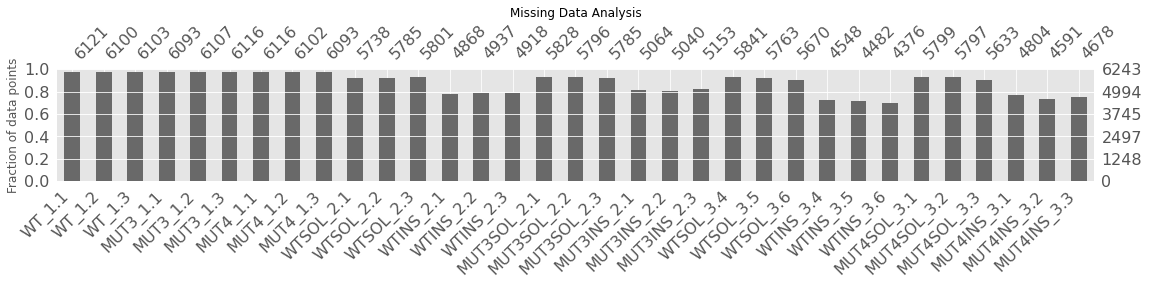

/var/folders/r1/gf3p5gjs5j9gw_49cj98r8b00000gp/T/ipykernel_75592/1333467333.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


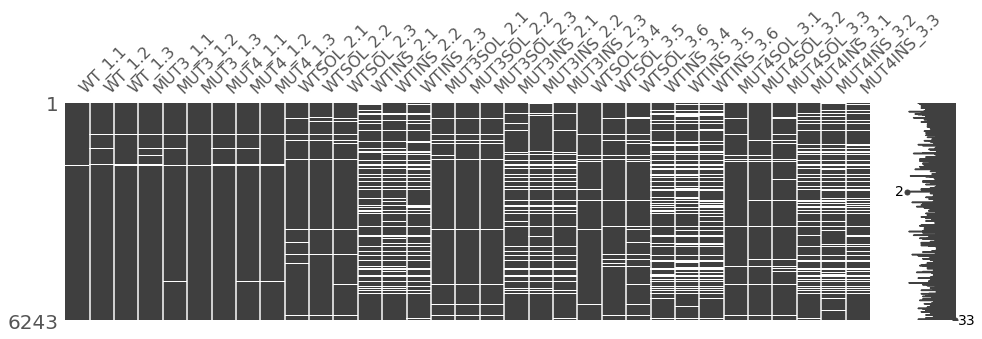

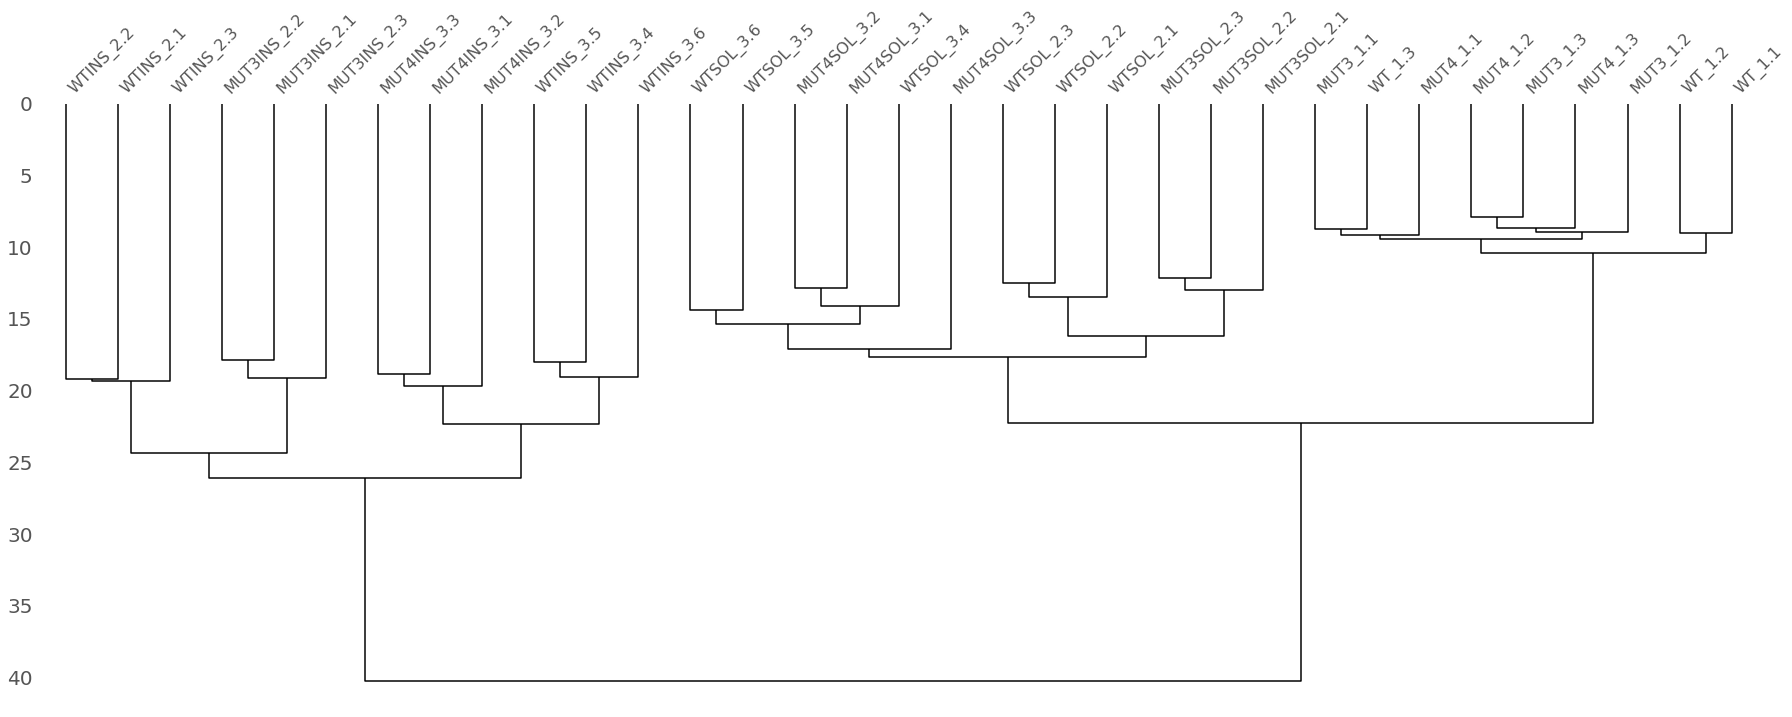

In [ ]:
dataset_viz = DatasetViz(df = filtered_quantification)
dataset_viz.analyse_missing_values(figsize=(16,4))

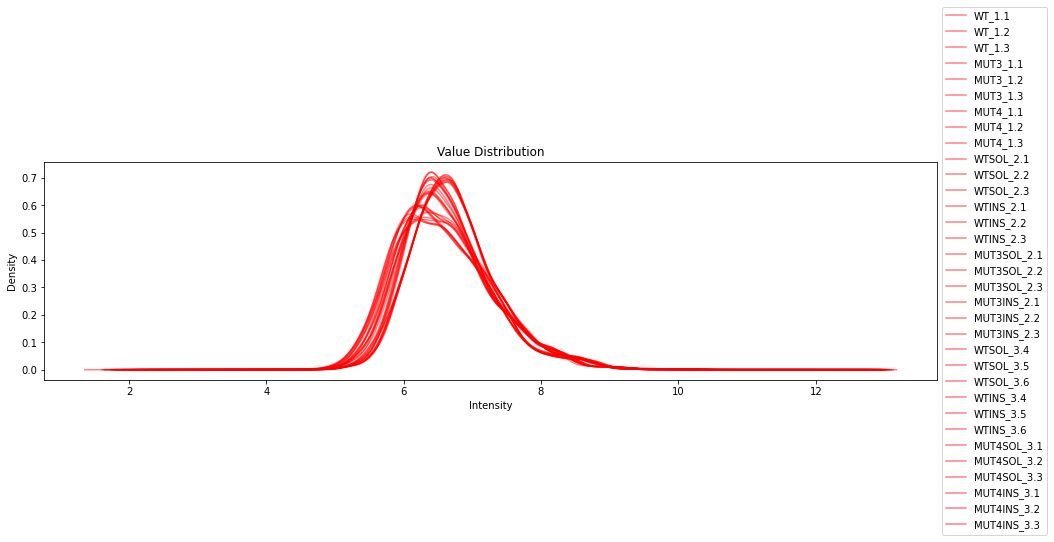

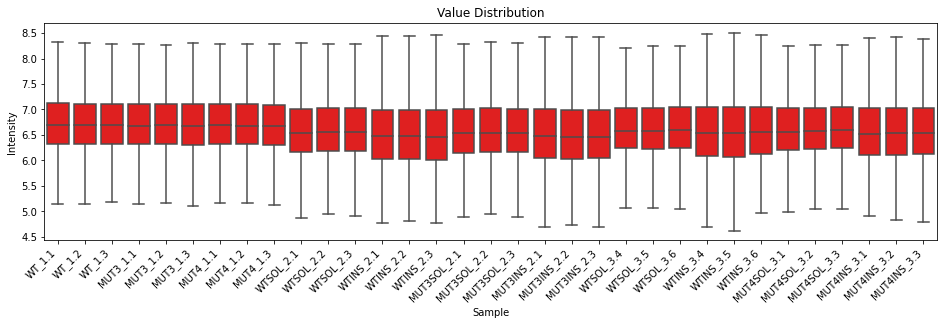

In [ ]:
dataset_viz.analyse_values_distribution(figsize=(16,4))

In [ ]:
#filtered_quantification.tail(50)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()